In [3]:
import pandas as pd
import re
import nltk
import contractions
import numpy as np
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
import joblib
from sklearn.metrics import accuracy_score

In [4]:
# Load your dataset
df = pd.read_csv("C:\\Users\\abhve\\Downloads\\trained.csv")

In [5]:
column = 'OR_user_description'
label_column = 'Annotate'


In [6]:
# Handle missing values
df[column] = df[column].fillna('')  # Replace NaN with an empty string

In [7]:
#Convert al values to string
df['Annotate'] = df['Annotate'].apply(lambda x: str(x))

#Remove all blank spaces
df['Annotate'] = df['Annotate'].str.replace(' ', '')

#Convert everything to lower 
df['Annotate'] = df['Annotate'].apply(lambda x: x.lower())

#Printing Unique Stance
unique_values = df['Annotate'].unique()
print(unique_values)

['ir' 'media' 'nu' 'incs' 'ncp' 'sss' 'antibjp' 'bjps' 'bjp' 'ss' 'ammk'
 'inc' 'ysrcps' 'cpim' 'aimim' 'aaps' 'tmc' 'mnss' 'aiadmks']


In [8]:
# Text Preprocessing
df[column] = df[column].apply(lambda x: str(x))
df[column] = df[column].apply(lambda x: x.lower())
df[column] = df[column].apply(lambda x: contractions.fix(x))
punctuations_regex = "!#%&\'()\*+,-/:;<=>?@[\\]^_`{|}~.1234567890"
df[column] = df[column].apply(lambda x: re.sub('[%s]' % re.escape(punctuations_regex), ' ', x))
df[column] = df[column].apply(lambda x: ' '.join(nltk.word_tokenize(x)))


In [9]:
# Load GloVe word vectors
glove_file_path = 'glove.6B.100d.txt'  
word_embeddings = {}
with open(glove_file_path, encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        word_embeddings[word] = coefs

In [10]:
# Function to get the vector representation of a sentence
def get_sentence_vector(sentence):
    if pd.isna(sentence):  # Check for NaN values
        return np.zeros(100)
    
    vectors = [word_embeddings.get(word, np.zeros(100)) for word in sentence.split()]
    vectors = [vec for vec in vectors if vec.shape == (100,)]  # Filter out zero vectors
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(100)  # Return zero vector if no valid vectors are found

In [11]:
# Apply GloVe vectors to each row
df['glove_vector'] = df[column].apply(get_sentence_vector)


In [12]:
# Create features from GloVe vectors
features = np.vstack(df['glove_vector'].to_numpy())

In [13]:
# Clustering
cluster_model = KMeans(n_clusters=200).fit(features)
df['cluster_label'] = cluster_model.labels_

C:\Users\abhve\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [14]:
# Encode Labels
label_encoder = LabelEncoder()
df[label_column] = label_encoder.fit_transform(df[label_column])

In [15]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(features, df[label_column], test_size=0.2, random_state=42)

In [16]:
# Training XGBoost (Weak supervision)
clf = XGBClassifier(n_jobs=-1, objective='multi:softmax')
clf = clf.fit(X_train, y_train)

In [17]:
# Save models
joblib.dump(clf, 'model_glove.keras')
joblib.dump(cluster_model, 'cluster_model.keras')
joblib.dump(label_encoder, 'label_encoder_glove.keras')


['label_encoder_glove.keras']

In [29]:
# Model Evaluation
y_true = label_encoder.inverse_transform(y_test)
y_pred = clf.predict(X_test)
y_pred_str = label_encoder.inverse_transform(y_pred)

print(classification_report(y_true, y_pred_str, digits=4))

              precision    recall  f1-score   support

        aaps     1.0000    1.0000    1.0000        26
     aiadmks     1.0000    1.0000    1.0000         3
       aimim     1.0000    0.8571    0.9231         7
        ammk     1.0000    1.0000    1.0000         3
     antibjp     1.0000    0.9317    0.9646       161
         bjp     1.0000    1.0000    1.0000        75
        bjps     0.8638    0.9937    0.9242       319
        cpim     1.0000    1.0000    1.0000         5
         inc     1.0000    1.0000    1.0000        61
        incs     0.9870    0.9268    0.9560        82
          ir     0.9982    0.9588    0.9781       582
       media     0.9985    0.9985    0.9985       666
        mnss     1.0000    1.0000    1.0000         6
         ncp     1.0000    1.0000    1.0000         8
          nu     1.0000    1.0000    1.0000       319
          ss     1.0000    1.0000    1.0000        12
         sss     1.0000    1.0000    1.0000        13
         tmc     1.0000    

In [110]:
#Labelling our dataset through our model

In [111]:
# Unlabeled dataset
unlabeled_df = pd.read_csv("C:\\Users\\abhve\\Downloads\\tested.csv")


In [112]:
column = 'OR_user_description'

In [113]:
unlabeled_df[column] = unlabeled_df[column].fillna('').astype(str)

In [114]:
# Text Preprocessing
unlabeled_df[column] = unlabeled_df[column].apply(lambda x: x.lower())
unlabeled_df[column] = unlabeled_df[column].apply(lambda x: contractions.fix(x))
punctuations_regex = "!#%&'()*+,-/:;<=>?@[\\]^_`{|}~.1234567890"
unlabeled_df[column] = unlabeled_df[column].apply(lambda x: re.sub('[%s]' % re.escape(punctuations_regex), ' ', x))
unlabeled_df[column] = unlabeled_df[column].apply(lambda x: ' '.join(nltk.word_tokenize(x)))

In [117]:
# Apply GloVe vectors to each row
unlabeled_df['glove_vector'] = df[column].apply(get_sentence_vector)

In [118]:
# Filter out vectors with size not equal to 100
unlabeled_df['glove_vector'] = unlabeled_df['glove_vector'].apply(lambda x: x if isinstance(x, np.ndarray) and x.shape == (100,) else np.zeros(100))

In [119]:
# Create features from GloVe vectors
new_features = np.vstack(unlabeled_df['glove_vector'].to_numpy())

In [120]:
# Load saved models
loaded_clf = joblib.load('model_glove.keras')
loaded_cluster_model = joblib.load('cluster_model.keras')
loaded_label_encoder = joblib.load('label_encoder_glove.keras')

In [121]:
# Apply XGBoost prediction
new_predictions = loaded_clf.predict(new_features)
unlabeled_df['Desc_Stance'] = loaded_label_encoder.inverse_transform(new_predictions)


In [122]:
unlabeled_df.to_csv("tested_glove.csv", index=False)

In [123]:
unlabeled_df


,Unnamed: 0,Sno,Tid,Tcreated_at,RT_screen_name,RT_userid,RT_usertext,RT_userlocation,RT_user_description,RT_user_verified,...,OR_user_friends_count,OR_user_favourites_count,OR_user_statuses_count,OR_user _created_at,OR_user_location.1,retweet_count,OR_user_full_text,Language,glove_vector,Desc_Stance
0,482550,651615,1109438897040384000,Sat Mar 23 12:57:00 +0000 2019,RT @007kiran_: 23 मई कांग्रेस गई😂😂\n\n#LokSabh...,007kiran_,702734923342462976,India Tweets in link👇👇,🚩🚩I am Not Supposed to Tell You☝️That || Natio...,False,...,407,4641,35871,Thu Feb 25 06:00:36 +0000 2016,India Tweets in link👇👇,24,23 मई कांग्रेस गई😂😂\n\n#LokSabhaElections2019 ...,hi,"[-0.044986077, -0.07062086, 0.28127724, -0.199...",ir
1,2022458,2625662,1117504572510167045,Sun Apr 14 19:07:06 +0000 2019,RT @007kiran_: कुमार विश्वास जी की इस बात से प...,VeerLotus,139007121,New Delhi ↔️Gurgaon ↔️Dehradun,मेरा गर्व भारतवर्ष🇮🇳 जय हिन्द बंदे मातरम🚩\n\n👉...,False,...,451,4772,40794,Thu Feb 25 06:00:36 +0000 2016,India,11,कुमार विश्वास जी की इस बात से पूरी तरह सहमत हू...,hi,"[-0.044986077, -0.07062086, 0.28127724, -0.199...",ir
2,62918,88303,1104775696474427392,Sun Mar 10 16:07:06 +0000 2019,RT @007kiran_: 23 मई कांग्रेस गई😂😂\n\n#LokSabh...,007kiran_,702734923342462976,India Tweets in link👇👇,🚩🚩I'm Not Supposed to Tell You☝️That || BJP su...,False,...,384,4558,34159,Thu Feb 25 06:00:36 +0000 2016,India Tweets in link👇👇,11,23 मई कांग्रेस गई😂😂\n\n#LokSabhaElections2019 ...,hi,"[-0.044986077, -0.07062086, 0.28127724, -0.199...",ir
3,1902190,2472067,1116941756304642048,Sat Apr 13 05:50:41 +0000 2019,RT @007kiran_: कुमार विश्वास जी की इस बात से प...,Poonams57222397,1065449077247279104,Uttar Pradesh,"सितम का कोई डर नहीं , साथ है तुम्हारा फिर और क...",False,...,450,4769,40540,Thu Feb 25 06:00:36 +0000 2016,India,5,कुमार विश्वास जी की इस बात से पूरी तरह सहमत हू...,hi,"[-0.044986077, -0.07062086, 0.28127724, -0.199...",ir
4,2020231,2622889,1117494921991217152,Sun Apr 14 18:28:46 +0000 2019,RT @007kiran_: कुमार विश्वास जी की इस बात से प...,bijendra125,1642600182,"अमरोहा(जे पी नगर) & मेरठ, भारत",श्री कृष्ण गोविँद हरे मुरारी। हे नाथ नारायण वा...,False,...,451,4772,40794,Thu Feb 25 06:00:36 +0000 2016,India,10,कुमार विश्वास जी की इस बात से पूरी तरह सहमत हू...,hi,"[-0.044986077, -0.07062086, 0.28127724, -0.199...",ir
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
192801,2588368,3360242,1119220942595485696,Fri Apr 19 12:47:21 +0000 2019,RT @zules7172: #HemantKarkare died in the line...,mat_jane_de_yar,914189502800846849,संघी के गले की हड्डी,"Aise Kaise Jaane de yaar, loot ka maal thori h...",False,...,103,9830,8299,Fri Jun 10 10:19:13 +0000 2011,india,32,#HemantKarkare died in the line of duty for In...,en,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",bjps
192802,2572890,3339888,1119168451124387840,Fri Apr 19 09:18:46 +0000 2019,RT @zules7172: #HemantKarkare died in the line...,indosecular,339273624,NaN,NaN,False,...,103,9829,8298,Fri Jun 10 10:19:13 +0000 2011,india,24,#HemantKarkare died in the line of duty for In...,en,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",bjps
192803,2420254,3135376,1118797237721559040,Thu Apr 18 08:43:42 +0000 2019,RT @zules7172: Every Vote counts\n\nEducate yo...,mat_jane_de_yar,914189502800846849,संघी के गले की हड्डी,"Aise Kaise Jaane de yaar, loot ka maal thori h...",False,...,103,9812,8266,Fri Jun 10 10:19:13 +0000 2011,india,8,Every Vote counts\n\nEducate yourself\n\nKnow ...,en,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",bjps
192804,2576946,3345388,1119181352308441088,Fri Apr 19 10:10:02 +0000 2019,RT @zules7172: #HemantKarkare died in the line...,ahmed_sf,123484032,"Bengaluru, India",I'm very simple person. i'm proud to be an ind...,False,...,103,9829,8298,Fri Jun 10 10:19:13 +0000 2011,india,28,#HemantKarkare died in the line of duty for In...,en,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",bjps


In [124]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

['aaps' 'aiadmks' 'aimim' 'ammk' 'antibjp' 'bjp' 'bjps' 'cpim' 'inc'
 'incs' 'ir' 'media' 'mnss' 'nan' 'ncp' 'nu' 'ss' 'sss' 'tmc' 'ysrcps']


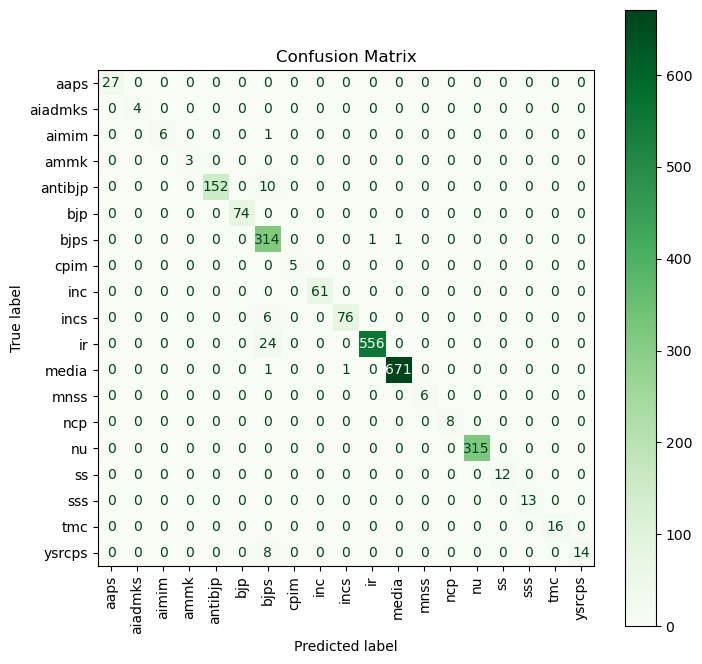

In [129]:
conf_matrix = confusion_matrix(y_true, y_pred_str)
classes = label_encoder.classes_
print(classes)
exclude_label = 'nan'
classes = [label for label in classes if label != exclude_label]

# Display Confusion Matrix
cm_display = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=classes)
fig, ax = plt.subplots(figsize=(8, 8))
cm_display.plot(cmap='Greens', values_format='d', ax=ax)

# Rotate x-axis labels by 180 degrees
ax.set_xticklabels(classes, rotation=90)

plt.title('Confusion Matrix')
plt.show()